# 1. Setup

## 1.1 Install Dependencies

In [3]:
#####

## 1.2 Import Dependencies

In [6]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [7]:
# Import tensorflow ddependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Set GPU Grouwth

In [9]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.4 Create Folder Structures

In [14]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

# 2. Collect Positives and Anchor

## 2.1 Untar Labelled Faces in the Wild Dataset

In [18]:
# https://vis-www.cs.umass.edu/lfw/

## 2.2 Collect Positive and Anchor Classes

In [21]:
# Import uuid library to generate unique image names
import uuid

In [23]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\ca966069-5300-11ef-8d0c-84fdd1f05fd1.jpg'

In [25]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)  # hoặc thử các giá trị khác như 1, 2, 3 nếu 0 không hoạt động
while cap.isOpened():
    ret, frame = cap.read()
    
    # Cut down frame to 250x250px
    frame = frame[90:90+250, 210:210+250, :]

    # Collect anchors
    if cv2.waitKey(1) & 0xFF == ord('a'):
        # Create the unique file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)

    # Collect positives
    if cv2.waitKey(1) & 0xFF == ord('p'):
        # Create the unique file path
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)

    # Show image back to screen
    cv2.imshow('BOB', frame)

    # Breaking gracefully
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()


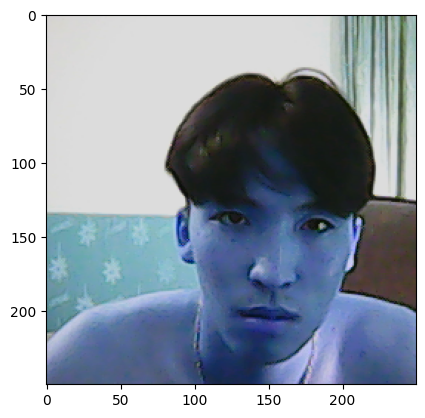

In [26]:
plt.imshow(frame)

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [31]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [32]:
dir_test = anchor.as_numpy_iterator()

In [33]:
print(dir_test.next())

b'data\\anchor\\0f75d755-4d00-11ef-b702-84fdd1f05fd1.jpg'


## 3.2 Preprocessing - Scale and Resize

In [38]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [40]:
img = preprocess('data\\anchor\\290288ac-4d00-11ef-bfbc-84fdd1f05fd1.jpg')

In [42]:
img.numpy().max()

0.96936274

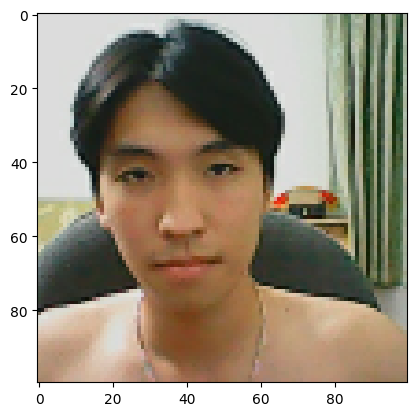

In [44]:
plt.imshow(img)

## 3.3 Create Labelled Dataset

In [47]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [49]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [51]:
samples = data.as_numpy_iterator()

In [53]:
example = samples.next()

In [55]:
example

(b'data\\anchor\\5de9eef6-4cfe-11ef-829d-84fdd1f05fd1.jpg',
 b'data\\positive\\f955f2ba-4cfe-11ef-a47a-84fdd1f05fd1.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [58]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [60]:
res = preprocess_twin(*example)

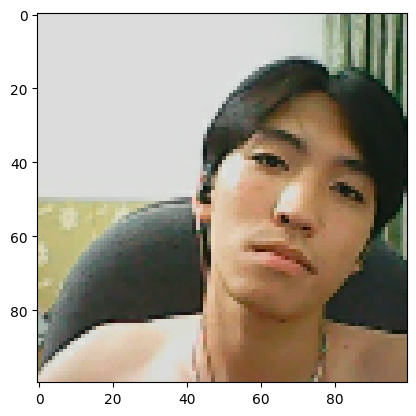

In [62]:
plt.imshow(res[1])

In [64]:
res[2]

1.0

In [66]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [68]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [70]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [74]:
inp = Input(shape=(100,100,3), name='input_image')

In [76]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [78]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [80]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [82]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [84]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [86]:

mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [88]:

mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [90]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [92]:
embedding = make_embedding()

In [94]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

## 4.2 Build Distance Layer

In [97]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [99]:
l1 = L1Dist()

In [101]:
# l1(anchor_embedding, validation_embedding)

## 4.3 Make Siamese Model

In [104]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [106]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [108]:
siamese_layer = L1Dist()

In [110]:
distances = siamese_layer(inp_embedding, val_embedding)

In [112]:
classifier = Dense(1, activation='sigmoid')(distances)

In [114]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [116]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [118]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [120]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [122]:
siamese_model = make_siamese_model()

In [124]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 5. Training

## 5.1 Setup Loss and Optimizer

In [128]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [130]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [133]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [136]:
test_batch = train_data.as_numpy_iterator()

In [138]:
batch_1 = test_batch.next()

In [139]:
X = batch_1[:2]

In [140]:
y = batch_1[2]

In [141]:
y

array([0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0.],
      dtype=float32)

In [146]:
np.array(X).shape

(2, 16, 100, 100, 3)

In [148]:
tf.losses.BinaryCrossentropy??

Init signature:
tf.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='auto',
    name='binary_crossentropy',
)
Source:        
@keras_export("keras.losses.BinaryCrossentropy")
class BinaryCrossentropy(LossFunctionWrapper):
    """Computes the cross-entropy loss between true labels and predicted labels.

    Use this cross-entropy loss for binary (0 or 1) classification applications.
    The loss function requires the following inputs:

    - `y_true` (true label): This is either 0 or 1.
    - `y_pred` (predicted value): This is the model's prediction, i.e, a single
      floating-point value which either represents a
      [logit](https://en.wikipedia.org/wiki/Logit), (i.e, value in [-inf, inf]
      when `from_logits=True`) or a probability (i.e, value in [0., 1.] when
      `from_logits=False`).

    **Recommended Usage:** (set `from_logits=True`)

    With `tf.keras` API:

    ```python
    model.compile(
      loss=tf.keras.losses

In [150]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

## 5.4 Build Training Loop

In [153]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [155]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

# 6. Evaluate Model

## 6.1 Import Metrics

In [162]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [165]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [167]:
# make predictions
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 3s 3s/step


In [169]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1]

In [171]:
y_true

array([0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1.],
      dtype=float32)

## 6.3 Calculate Metrics

In [174]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [176]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

## 6.4 Viz Results

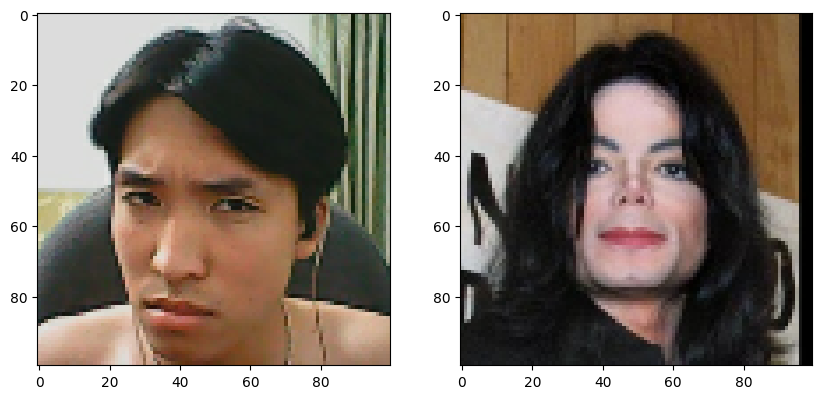

In [179]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

# 7. Save Model

In [182]:
L1Dist

__main__.L1Dist

In [158]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [184]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 25ms/step


array([[5.0449960e-11],
       [6.0875978e-11],
       [2.6682134e-11],
       [9.9997544e-01],
       [1.0000000e+00],
       [1.2898854e-10],
       [1.5719298e-09],
       [1.2601634e-03],
       [9.9999952e-01],
       [1.0000000e+00],
       [2.5771363e-10],
       [1.0000000e+00],
       [1.0000000e+00],
       [7.7475110e-10],
       [3.0068671e-07],
       [9.9988079e-01]], dtype=float32)

In [186]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

## 8. Real Time Test

## 8.1 Verification Function

In [190]:
os.listdir(os.path.join('application_data', 'verification_images'))

['0456715f-4cff-11ef-ad34-84fdd1f05fd1.jpg',
 '04eeb96c-4cff-11ef-a7c3-84fdd1f05fd1.jpg',
 '0897a8fe-4cff-11ef-a261-84fdd1f05fd1.jpg',
 '0932ef67-4cff-11ef-acbf-84fdd1f05fd1.jpg',
 '09b4fa34-4cff-11ef-ab36-84fdd1f05fd1.jpg',
 '0a932a6f-4cff-11ef-b261-84fdd1f05fd1.jpg',
 '0ab038af-4cff-11ef-ba6e-84fdd1f05fd1.jpg',
 '11b73893-4cff-11ef-91b5-84fdd1f05fd1.jpg',
 '13e755a0-4cff-11ef-93e8-84fdd1f05fd1.jpg',
 '1463865f-4cff-11ef-ab0b-84fdd1f05fd1.jpg',
 '16f872e2-4cff-11ef-a48e-84fdd1f05fd1.jpg',
 '17de9f9b-4cff-11ef-835e-84fdd1f05fd1.jpg',
 '1a537fb0-4cff-11ef-aab7-84fdd1f05fd1.jpg',
 '20e00d68-4cff-11ef-89ed-84fdd1f05fd1.jpg',
 '21a1b88f-4cff-11ef-b639-84fdd1f05fd1.jpg',
 '21be60eb-4cff-11ef-ae35-84fdd1f05fd1.jpg',
 '239746b5-4cff-11ef-8c81-84fdd1f05fd1.jpg',
 '24b0555b-4cff-11ef-b972-84fdd1f05fd1.jpg',
 '24d19766-4cff-11ef-9a3b-84fdd1f05fd1.jpg',
 '25baa17e-4cff-11ef-9e6f-84fdd1f05fd1.jpg',
 '25d732fc-4cff-11ef-8669-84fdd1f05fd1.jpg',
 '4160106e-4cff-11ef-ad01-84fdd1f05fd1.jpg',
 '4a532e94

In [192]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [194]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\0456715f-4cff-11ef-ad34-84fdd1f05fd1.jpg
application_data\verification_images\04eeb96c-4cff-11ef-a7c3-84fdd1f05fd1.jpg
application_data\verification_images\0897a8fe-4cff-11ef-a261-84fdd1f05fd1.jpg
application_data\verification_images\0932ef67-4cff-11ef-acbf-84fdd1f05fd1.jpg
application_data\verification_images\09b4fa34-4cff-11ef-ab36-84fdd1f05fd1.jpg
application_data\verification_images\0a932a6f-4cff-11ef-b261-84fdd1f05fd1.jpg
application_data\verification_images\0ab038af-4cff-11ef-ba6e-84fdd1f05fd1.jpg
application_data\verification_images\11b73893-4cff-11ef-91b5-84fdd1f05fd1.jpg
application_data\verification_images\13e755a0-4cff-11ef-93e8-84fdd1f05fd1.jpg
application_data\verification_images\1463865f-4cff-11ef-ab0b-84fdd1f05fd1.jpg
application_data\verification_images\16f872e2-4cff-11ef-a48e-84fdd1f05fd1.jpg
application_data\verification_images\17de9f9b-4cff-11ef-835e-84fdd1f05fd1.jpg
application_data\verification_images\1a537fb0-4cff-11ef-aab7-84f

In [196]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verification

In [199]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[90:90+250, 210:210+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 24ms/step
True
1/1 [==============================] - 0s 23ms/step
True
1/1 [==============================] - 0s 30ms/step
False
1/1 [==============================] - 0s 31ms/step
True
1/1 [==============================] - 0s 31ms/step
False


In [209]:
results

[array([[9.212955e-13]], dtype=float32),
 array([[5.1649965e-12]], dtype=float32),
 array([[6.4152655e-12]], dtype=float32),
 array([[4.62873e-10]], dtype=float32),
 array([[3.4747235e-13]], dtype=float32),
 array([[8.750701e-12]], dtype=float32),
 array([[2.2983282e-11]], dtype=float32),
 array([[2.5984636e-14]], dtype=float32),
 array([[3.667361e-12]], dtype=float32),
 array([[1.1214319e-12]], dtype=float32),
 array([[6.293448e-13]], dtype=float32),
 array([[2.5444097e-08]], dtype=float32),
 array([[4.170084e-08]], dtype=float32),
 array([[1.6638765e-10]], dtype=float32),
 array([[7.380056e-11]], dtype=float32),
 array([[1.12773506e-10]], dtype=float32),
 array([[1.0835847e-11]], dtype=float32),
 array([[1.247023e-10]], dtype=float32),
 array([[1.26320705e-08]], dtype=float32),
 array([[1.5285176e-09]], dtype=float32),
 array([[1.4176061e-09]], dtype=float32),
 array([[6.356784e-13]], dtype=float32),
 array([[2.2608078e-10]], dtype=float32),
 array([[3.6150157e-13]], dtype=float32),
